In [1]:
import nrrd
import os
import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import csv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, save_model
import cv2

In [2]:
data_path = 'F:\\Birva_Harsh\\NEW_KNEE_CT_100_V1\\Train'

In [3]:
ankle_paths = []
mask_paths = []
csv_paths = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    for file in os.listdir(folder_path):
        if file.endswith('.nrrd'):
            if 'segmentation' in file.lower():
                mask_path = os.path.join(folder_path, file)
                
                mask_paths.append(mask_path)
            else:
                ankle_path = os.path.join(folder_path, file)
                ankle_paths.append(ankle_path)
                
        if file == 'LM_INFO_voxel_Coord_tibia.csv':
            csv_path = os.path.join(folder_path, file)
            csv_paths.append(csv_path)

In [4]:
df_train = pd.DataFrame({'ankle': ankle_paths, 'mask': mask_paths})

In [5]:
len(df_train)

70

In [6]:
data_path = 'F:\\Birva_Harsh\\NEW_KNEE_CT_100_V1\\Test'

In [7]:
ankle_paths = []
mask_paths = []
csv_paths_test = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    for file in os.listdir(folder_path):
        if file.endswith('.nrrd'):
            if 'segmentation' in file.lower():
                mask_path = os.path.join(folder_path, file)
                
                mask_paths.append(mask_path)
            else:
                ankle_path = os.path.join(folder_path, file)
                ankle_paths.append(ankle_path)
                
        if file == 'LM_INFO_voxel_Coord_tibia.csv':
            csv_path = os.path.join(folder_path, file)
            csv_paths_test.append(csv_path)

In [8]:
df_test = pd.DataFrame({'ankle': ankle_paths, 'mask': mask_paths})

In [9]:
len(df_test)

20

In [10]:
def read_csv_to_dict_LM_INFO(csv_file):
    LM_INFO = {}
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)       
        for rows in reader:
            LM_INFO[rows[0]] = np.asarray([float(rows[1]), float(rows[2]), float(rows[3])])
            #print(rows[0], ':', float(rows[1]), float(rows[2]), float(rows[3]))
            
    return LM_INFO

In [11]:
def zoom_1mm(img,original_space,new_space=[1.0,1.0,1.0]):
    zoom_factor = [original_space[i] / new_space[i] for i in range(3)]
    zoomed_image = zoom(img, zoom_factor, order=0)
    
    return zoomed_image

In [12]:
def ankle_centre(path, original_space):
    AC = read_csv_to_dict_LM_INFO(path)['TA']
    AC_1mm = [round(original_space[i] * AC[i]) for i in range(3)]
    
    return AC_1mm

In [13]:
def CROP_3D_CT_IMAGE_AT_GIVEN_POINT_NEW_256(img, centered_at, crop_size):
    crop_size = np.asanyarray(crop_size)
    img = np.pad(img, ((128,128),(128,128),(128,128)),'edge')   

    sp_idx = np.asarray(128+centered_at-crop_size//2,dtype=int)
    ep_idx = np.asarray(128+centered_at+crop_size//2,dtype=int)
       
    return img[sp_idx[0]:ep_idx[0], sp_idx[1]:ep_idx[1], sp_idx[2]:ep_idx[2]]

In [14]:
crop_ankle_train = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\train\\Ankle'
crop_mask_train = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\train\\Mask'

In [15]:
for i in range(len(df_train)):
    img, kinfo = nrrd.read(df_train.loc[i,'ankle'])
    mask, minfo = nrrd.read(df_train.loc[i,'mask'])
    
    spc_dir = np.diag(kinfo['space directions'])
    
    img_1mm = zoom_1mm(img, spc_dir)
    mask_1mm = zoom_1mm(mask, spc_dir)
    
    AC = ankle_centre(csv_paths[i], spc_dir)
    
    kinfo['sizes'] = np.array([256.0,256.0,256.0])
    minfo['sizes'] = np.array([256.0,256.0,256.0])
    kinfo['space directions'] = np.eye(3)
    minfo['space directions'] = np.eye(3)
    
    for j in range(5):
        print(f"{os.path.basename(os.path.dirname(df_train.loc[i,'ankle']))}_{j+1}")
        shift = np.random.randint(-30,30,size=3)
        shift_AC = AC - shift
        
        crop_ankle = CROP_3D_CT_IMAGE_AT_GIVEN_POINT_NEW_256(img_1mm, shift_AC, [256,256,256])
        crop_mask = CROP_3D_CT_IMAGE_AT_GIVEN_POINT_NEW_256(mask_1mm, shift_AC, [256,256,256])
        
        output_img_path = os.path.join(crop_ankle_train, f"{os.path.basename(os.path.dirname(df_train.loc[i,'ankle']))}_{j+1}.nrrd")
        output_mask_path = os.path.join(crop_mask_train, f"{os.path.basename(os.path.dirname(df_train.loc[i,'ankle']))}_{j+1}.nrrd")
        
        nrrd.write(output_img_path, crop_ankle, kinfo)
        nrrd.write(output_mask_path, crop_mask, minfo)

Abhijit Banerjeer_1
Abhijit Banerjeer_2
Abhijit Banerjeer_3
Abhijit Banerjeer_4
Abhijit Banerjeer_5
Amar_Bahadur_Singh_70_M_1
Amar_Bahadur_Singh_70_M_2
Amar_Bahadur_Singh_70_M_3
Amar_Bahadur_Singh_70_M_4
Amar_Bahadur_Singh_70_M_5
AminChand Mehta_1
AminChand Mehta_2
AminChand Mehta_3
AminChand Mehta_4
AminChand Mehta_5
Amita_Pandey_62_F_1
Amita_Pandey_62_F_2
Amita_Pandey_62_F_3
Amita_Pandey_62_F_4
Amita_Pandey_62_F_5
Anita Chanan_1
Anita Chanan_2
Anita Chanan_3
Anita Chanan_4
Anita Chanan_5
Archana_Sawhney_57_F_1
Archana_Sawhney_57_F_2
Archana_Sawhney_57_F_3
Archana_Sawhney_57_F_4
Archana_Sawhney_57_F_5
Ashokkumar_Shah_71YM_1
Ashokkumar_Shah_71YM_2
Ashokkumar_Shah_71YM_3
Ashokkumar_Shah_71YM_4
Ashokkumar_Shah_71YM_5
Ashutosh_Tiwari_69_M_1
Ashutosh_Tiwari_69_M_2
Ashutosh_Tiwari_69_M_3
Ashutosh_Tiwari_69_M_4
Ashutosh_Tiwari_69_M_5
BALA DEVI RT KNEE_1
BALA DEVI RT KNEE_2
BALA DEVI RT KNEE_3
BALA DEVI RT KNEE_4
BALA DEVI RT KNEE_5
Balwinder Kaur_1
Balwinder Kaur_2
Balwinder Kaur_3
Balwinder

In [16]:
crop_ankle_test = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\test\\Ankle'
crop_mask_test = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\test\\Mask'

In [17]:
for i in range(len(df_test)):
    img, kinfo = nrrd.read(df_test.loc[i,'ankle'])
    mask, minfo = nrrd.read(df_test.loc[i,'mask'])
    
    spc_dir = np.diag(kinfo['space directions'])
    
    img_1mm = zoom_1mm(img, spc_dir)
    mask_1mm = zoom_1mm(mask, spc_dir)
    
    AC = ankle_centre(csv_paths_test[i], spc_dir)
    
    kinfo['sizes'] = np.array([256.0,256.0,256.0])
    minfo['sizes'] = np.array([256.0,256.0,256.0])
    kinfo['space directions'] = np.eye(3)
    minfo['space directions'] = np.eye(3)
    
    for j in range(5):
        shift = np.random.randint(-30,30,size=3)
        shift_AC = AC - shift
        
        crop_ankle = CROP_3D_CT_IMAGE_AT_GIVEN_POINT_NEW_256(img_1mm, shift_AC, [256,256,256])
        crop_mask = CROP_3D_CT_IMAGE_AT_GIVEN_POINT_NEW_256(mask_1mm, shift_AC, [256,256,256])
        
        output_img_path = os.path.join(crop_ankle_test, f"{os.path.basename(os.path.dirname(df_test.loc[i,'ankle']))}_{j+1}.nrrd")
        output_mask_path = os.path.join(crop_mask_test, f"{os.path.basename(os.path.dirname(df_test.loc[i,'ankle']))}_{j+1}.nrrd")
        
        nrrd.write(output_img_path, crop_ankle, kinfo)
        nrrd.write(output_mask_path, crop_mask, minfo)
        
        print(f"{os.path.basename(os.path.dirname(df_test.loc[i,'ankle']))}_{j+1}")

Shobhnaben_H_Shah_F74Y_1
Shobhnaben_H_Shah_F74Y_2
Shobhnaben_H_Shah_F74Y_3
Shobhnaben_H_Shah_F74Y_4
Shobhnaben_H_Shah_F74Y_5
Soma__Mondal_1
Soma__Mondal_2
Soma__Mondal_3
Soma__Mondal_4
Soma__Mondal_5
SUKHBIR KAUR LT KNEE_1
SUKHBIR KAUR LT KNEE_2
SUKHBIR KAUR LT KNEE_3
SUKHBIR KAUR LT KNEE_4
SUKHBIR KAUR LT KNEE_5
Sumangla naithani lt_1
Sumangla naithani lt_2
Sumangla naithani lt_3
Sumangla naithani lt_4
Sumangla naithani lt_5
Sumangla_Naithani rt_1
Sumangla_Naithani rt_2
Sumangla_Naithani rt_3
Sumangla_Naithani rt_4
Sumangla_Naithani rt_5
Suman_Devi_50_F_1
Suman_Devi_50_F_2
Suman_Devi_50_F_3
Suman_Devi_50_F_4
Suman_Devi_50_F_5
SUNITA KULAKARNI LT KNEE_1
SUNITA KULAKARNI LT KNEE_2
SUNITA KULAKARNI LT KNEE_3
SUNITA KULAKARNI LT KNEE_4
SUNITA KULAKARNI LT KNEE_5
SUSHMA MAGO LT KNEE_1
SUSHMA MAGO LT KNEE_2
SUSHMA MAGO LT KNEE_3
SUSHMA MAGO LT KNEE_4
SUSHMA MAGO LT KNEE_5
Sushma_Sharma_82_F_1
Sushma_Sharma_82_F_2
Sushma_Sharma_82_F_3
Sushma_Sharma_82_F_4
Sushma_Sharma_82_F_5
Tajinder_Kaur_5

In [18]:
def plot_3d(img,mask):
    plt.figure(figsize=(15,8))
    plt.subplot(2, 3, 1)
    plt.imshow(img[128,:,:].T,cmap='gray')
    plt.axis('off')
    plt.title("X")
    
    plt.subplot(2, 3, 2)
    plt.imshow(img[:,128,:].T,cmap='gray')
    plt.axis('off')
    plt.title("Y")
    
    plt.subplot(2, 3, 3)
    plt.imshow(img[:,:,128].T,cmap='gray')
    plt.axis('off')
    plt.title("Z")
    
    
    plt.subplot(2, 3, 4)
    plt.imshow(mask[128,:,:].T,interpolation='nearest')
    plt.axis('off')
    plt.title("Mask X")
    
    plt.subplot(2, 3, 5)
    plt.imshow(mask[:,128,:].T,interpolation='nearest')
    plt.axis('off')
    plt.title("Mask Y")
    
    plt.subplot(2, 3, 6)
    plt.imshow(mask[:,:,128].T,interpolation='nearest')
    plt.axis('off')
    plt.title("Mask Z")
plt.show()

In [23]:
img, info = nrrd.read(f'F:\\Birva_Harsh\\Ankle_Crop_Data\\train\\Ankle\\AminChand Mehta_1.nrrd')
mask, info = nrrd.read(f'F:\\Birva_Harsh\\Ankle_Crop_Data\\train\\Mask\\AminChand Mehta_1.nrrd')

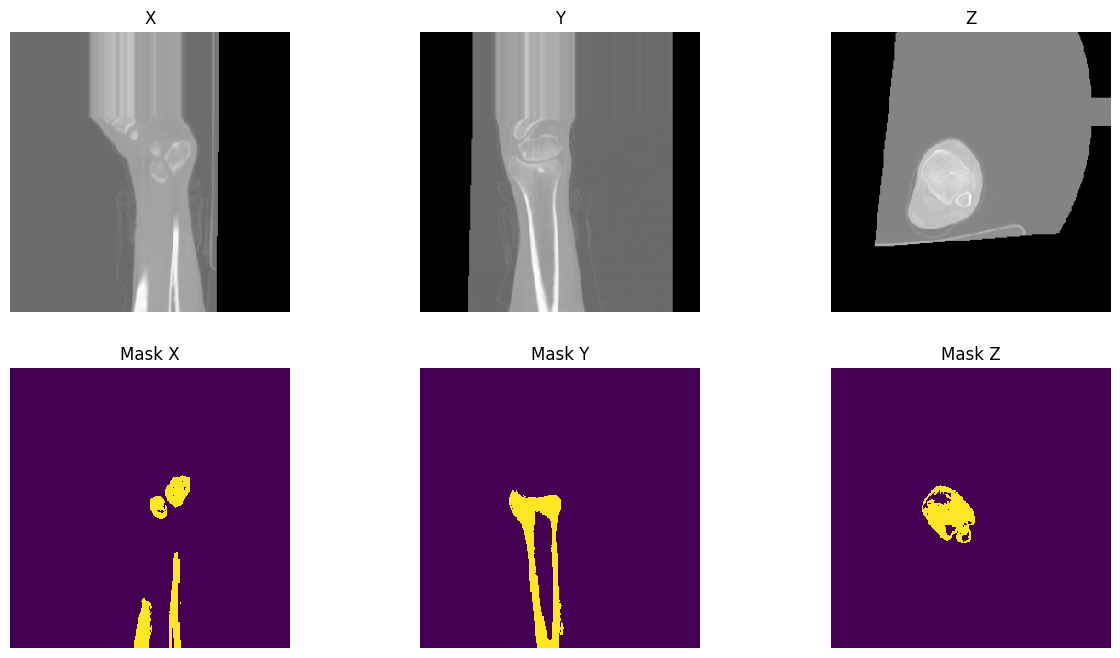

In [24]:
plot_3d(img,mask)